# TP2: Équation de la chaleur

Le but de ce TP est de calculer numériquement de deux façons différentes la solution du problème de diffusion avec conditions au bord de type Neumann,
$$
\begin{cases}
    \partial_t u(x,t) + \partial_{xx}^2 u = 0, & (x,t) \in (0,1) \times (0, \infty), \\
    u(x, 0) = u_0(x), \\
    \partial_x u(0, t) = \partial_x u(1,t) = 0 .
\end{cases}
$$
Ce problème d'évolution peut modéliser, par exemple, la densité de probabilité d'une particule en mouvement brownien dans une boîte.

Pour les applications, on choisira la condition initiale
$$
u_0(x) = \begin{cases}
    1 & \text{si~~} 1/4 \leq x \leq 1/2, \\
    0 & \text{sinon}.
\end{cases}
$$

### 1. Différences finies et Euler explicite

On cherche d'abord à calculer une solution numérique à ce problème par différences finies, en ne faisant que des calculs explicites avec la méthode d'Euler.

#### 1.1/ Utilitaires de discrétisation

**1.1.a)** Écrire une fonction `neumann_discretisation` qui prend en entrée la taille du système `N` et qui renvoie le vecteur de points de collocation $(x_1, ..., x_N)^{\sf T}$ associé. Valider cette fonction en affichant le résultat de `neumann_discretisation(2)` grâce à la fonction `display`.

**1.1.b)** Écrire une fonction `poisson_matrix` qui prend en entrée la taille du système et qui construit la matrice de Poisson associée. Valider cette fonction en affichant le résultat de `poisson_matrix(5)`. Pour éviter d'allouer de la mémoire inutile, on utilisera la structure `Tridiagonal` du module `LinearAlgebra`.

**1.1.c)** Surcharger la fonction `mul!` pour les matrices `Tridiagonal`.

In [1]:
using LinearAlgebra: Tridiagonal

# 1.1.a
neumann_discretisation(N) = [(i-0.5)/N for i in 1:N]

display(neumann_discretisation(2)) # on trouve bien 2 nœuds dans ]0,1[

# 1.1.b
poisson_matrix(N) = Tridiagonal(-ones(N-1), [1.0; 2*ones(N-2); 1.0], -ones(N-1)) # ; => concatenation, ',' => nouveau vect

display(poisson_matrix(5))

# 1.1.c
function mul!(b::AbstractVector, A::Tridiagonal, x::AbstractVector)
    @. b = 0 # rempli b in place
    b[1] = A[1,1] * x[1] + A[1,2] * x[2]
    @inbounds for i in 2 : length(x)-1 # @inbounds => ne verifie ce qu'il y a dans le vec ni sa taille -> opti
        b[i] += A[i,i-1] * x[i-1] + A[i,i] * x[i] + A[i, i+1] * x[i+1]
    end
    b[end] = A[end,end-1] * x[end-1] + A[end,end] * x[end]
end
# plus simple:
# using LinearAlgebra: mul!

2-element Vector{Float64}:
 0.25
 0.75

5×5 Tridiagonal{Float64, Vector{Float64}}:
  1.0  -1.0    ⋅     ⋅     ⋅ 
 -1.0   2.0  -1.0    ⋅     ⋅ 
   ⋅   -1.0   2.0  -1.0    ⋅ 
   ⋅     ⋅   -1.0   2.0  -1.0
   ⋅     ⋅     ⋅   -1.0   1.0

mul! (generic function with 1 method)

#### 1.2/ Méthode d'Euler explicite

Écrire une fonction `simulate_explicit_euler` qui prend en entrée une fonction `u0` de conditions initiales, `Nx` le nombre de points en espace, `T` le temps final et `Nt` le nombre de pas de temps, et qui renvoie le maillage $(x_i)$ ainsi que la solution numérique $U^{N_t}_i \approx u(x_i, T)$ calculée par méthode d'Euler explicite. On pourra utiliser la structure `Diagonal` ou la variable "magique" `I` de `LinearAlgebra`.

In [2]:
using LinearAlgebra: I

function explicit_euler_loop!(u, u_tmp, S, Nt)
    @inbounds for n in 1:Nt
        mul!(u_tmp, S, u)
        u .= u_tmp # memory copy, less efficient than an address swap `u, u_tmp = u_tmp, u`
    end
end

function simulate_explicit_euler(u0 :: Function, Nx :: Int, T :: Float64, Nt :: Int)
    # initialise scheme
    x = neumann_discretisation(Nx)
    dx, dt = x[2] - x[1], T / Nt
    S = I - dt / dx^2 * poisson_matrix(Nx)

    # initialise solution
    u = u0.(x)
    u_tmp = similar(u)
    explicit_euler_loop!(u, u_tmp, S, Nt)
    return x, u
end

simulate_explicit_euler (generic function with 1 method)

#### 1.3/ Solution et CFL

Avec $N_x = 1000$, calculer la solution après 100 pas de temps avec une condition CFL $\Delta t / \Delta x^2 = 0.51$ et la tracer. Quelle différence observe-t-on par rapport aux solutions au même temps final avec des conditions CFL $\Delta t / \Delta x^2 \in \{0.1, 0.5\}$ ?

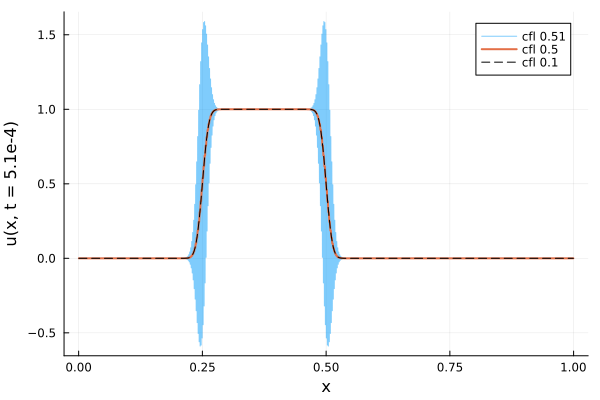

In [3]:
using Plots

initial_condition(x) = Float64(0.25 < x < 0.5) # u0

Nx = 1000
dx = 1.0 / Nx

Nt1 = 100
cfl1 = 0.51
dt = cfl1 * dx^2
T = dt * Nt1

plot(xlabel="x", ylabel="u(x, t = 5.1e-4)", legend=:topright)

x, u1 = simulate_explicit_euler(initial_condition, Nx, T, Nt1)
plot!(x, u1, label="cfl 0.51", alpha=0.5)

cfl2 = 0.5
Nt2 = Int(T / (cfl2 * dx^2))
x, u2 = simulate_explicit_euler(initial_condition, Nx, T, Nt2)
plot!(x, u2, label="cfl 0.5", linewidth=2)

cfl3 = 0.1
Nt3 = Int(T / (cfl3 * dx^2))
x, u3 = simulate_explicit_euler(initial_condition, Nx, T, Nt3)
plot!(x, u3, label="cfl 0.1", linestyle=:dash, color=:black)

### 2. Implémentation de méthodes implicites

Afin de s'affranchir de la contrainte de CFL, on cherche maintenant à implémenter des schémas temporels implicites.

#### 2.1/ Utilitaires pour la factorisation LU

Reprendre le TP précédent pour définir une structure `TridiagLU` avec les routines `factorize!`, `mul!` et `solve!`, ainsi que le constructeur `TridiagLU(A::AbstractMatrix)`.

Tester ce code sur la matrice $A_3 = \begin{pmatrix} 2 & -1 & 0 \\ -1 & 2 & -1 \\ 0 & -1 & 2 \end{pmatrix}$, en comparant avec une factorisation LU manuelle.

In [4]:
"Factorisation LU pour une matrice tridiagonale"
struct TridiagLU
    lower :: Vector{Float64}
    diag :: Vector{Float64}
    upper :: Vector{Float64}
end

"Initialisation de la mémoire pour une factorisation n×n"
TridiagLU(n::Int64) = TridiagLU(zeros(n-1), zeros(n), zeros(n-1))
"Dimensions de la matrice représentée"
Base.size(LU::TridiagLU) = (length(LU.diag), length(LU.diag))

function factorize!(LU::TridiagLU, A::AbstractMatrix)
    n = size(A, 1)
    lower, diag, upper = zeros(n-1), zeros(n), zeros(n-1)
    LU.diag[1] = A[1, 1]
    for i = 2:n
        LU.lower[i-1] = A[i, i-1] / LU.diag[i-1] 
        LU.upper[i-1] = A[i-1, i]
        LU.diag[i] = A[i, i] - LU.lower[i-1] * LU.upper[i-1]
    end
    return LU
end

function TridiagLU(A::AbstractMatrix)
    LU = TridiagLU(size(A, 1))  # on initialise la mémoire
    factorize!(LU, A)           # on effectue la factorisation
end

function mul!(b::Vector{Float64}, LU::TridiagLU, x::Vector{Float64})
    # fonction pas utilisée ici, et probablement moins efficace que multiplier par A = LU directement, 
    # mais l'implémentation est rigolotte
    n, = size(LU)
    @. b = LU.diag * x # b = diag(U) * x
    for i in 1 : n-1
        b[i] += LU.upper[i] * x[i+1] # b = b + (U sans diag) * x
    end
    for i in reverse(2 : n)
        b[i] += LU.lower[i-1] * b[i-1] # b = L * b
    end
    return b
end

function _solve_l!(y, LU, b)
    n = length(y)
    y[1] = b[1]
    @inbounds for i in 2:n
        y[i] = b[i] - LU.lower[i-1] * y[i-1]
    end
    return y 
end

function _solve_u!(x, LU, y)
    n = length(x)
    x[n] = y[n] / LU.diag[n]
    @inbounds for i in reverse(1:n-1)
        x[i] = (y[i] - LU.upper[i] * x[i+1]) / LU.diag[i]
    end
    return x 
end

"""
    solve!(x::Vector{Float64}, LU::TridiagLU, b::Vector{Float64})

Résout le système `LU*x = b` en modifiant `x` "in-place".
"""
function solve!(x::Vector{Float64}, LU::TridiagLU, b::Vector{Float64})
    _solve_l!(x, LU, b)
    _solve_u!(x, LU, x)
    return x
end

solve!

#### 2.1. Implémentation du $\theta$-schéma

Écrire une fonction `simulate_theta_scheme` qui prend en entrée les mêmes arguments que la fonction `simulate_explicit_euler` mais avec en plus un argument optionnel `θ = 0.5`. Cette fonction doit renvoyer le maillage $(x_i)$ ainsi que la solution numérique $U^{N_t}_i \approx u(x_i, T)$ calculée avec le $\theta$-schéma. On utilisera la factorisation LU précédemment implémentée.

In [5]:
function theta_scheme_loop!(u, u_tmp, S_exp, LU_imp, Nt)
    @inbounds for n in 1:Nt
        mul!(u_tmp, S_exp, u)
        solve!(u, LU_imp, u_tmp)
    end
    return u
end

function simulate_theta_scheme(u0 :: Function, Nx :: Int64, T :: Float64, Nt :: Int64; θ = 0.5)
    # initialise mesh
    x = neumann_discretisation(Nx)
    dx, dt = x[2] - x[1], T / Nt

    # initialise scheme
    A = poisson_matrix(Nx)
    S_exp = I - (1 - θ) * dt / dx^2 * A
    S_imp = I + θ * dt / dx^2 * A
    LU_imp = TridiagLU(S_imp)

    # initialise solution
    u = u0.(x)
    u_tmp = similar(u)
    # loop to fill solution
    theta_scheme_loop!(u, u_tmp, S_exp, LU_imp, Nt) # bizarrement, si on le met pas dans une fonction séparée, la boucle fait des allocations
    return x, u
end

simulate_theta_scheme (generic function with 1 method)

#### 2.2. Affichage et validation

Pour $N_x = 1000$, afficher les solutions obtenues avec $\Delta t = 10^{-4}$ aux temps $t = 10^{-2}$, $t = 3\cdot 10^{-2}$ et $t = 5\cdot 10^{-2}$, pour $\theta = 1$ et $\theta = 1/2$. Commenter.

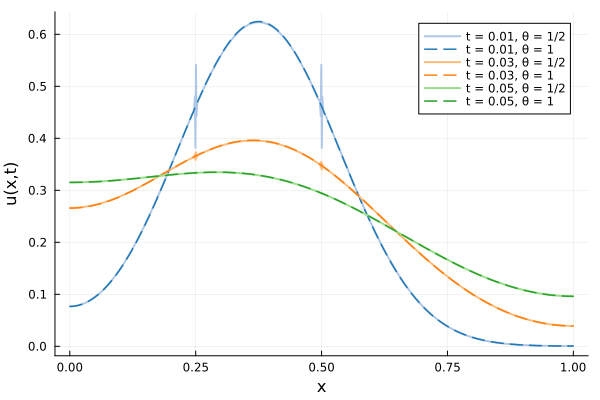

In [6]:
Nx = 1000
tf, dt = [1e-2, 3e-2, 5e-2], 1e-4
colors = palette(:tab20) #palettes : https://docs.juliaplots.org/latest/generated/colorschemes/#Pre-defined-ColorSchemes
p = plot(xlabel="x", ylabel="u(x,t)", legend=:topright)
for (k, t) in enumerate(tf)
    Nt = Int64(t / dt)

    x, u2 = simulate_theta_scheme(initial_condition, Nx, t, Nt, θ = 0.5)
    plot!(p, x, u2, label="t = $t, θ = 1/2", color=colors[2*k], linewidth=2)
    
    x, u1 = simulate_theta_scheme(initial_condition, Nx, t, Nt, θ = 1.0)
    plot!(p, x, u1, label="t = $t, θ = 1", color=colors[2*k-1], linestyle=:dash, linewidth=1.5)
end
display(p)

#### 2.3/ Convergence de Crank-Nicholson

**2.3.a)** Pour $N_x = 1000$, calculer une solution précise avec $\theta = 1/2$ au temps $T = 10^{-2}$ en utilisant un pas de temps $\Delta t = 10^{-8}$.

**2.3.b)** Dans une nouvelle cellule, pour $\theta = 1/2$, calculer l'erreur en norme $\ell^2$ pour les pas de temps $\Delta t \in \{10^{-2}, 5\cdot 10^{-3}, 2\cdot 10^{-3}, 10^{-3}, 5\cdot 10^{-4}, ..., 10^{-7}\}$. On pourra utiliser la fonction `norm` de `LinearAlgebra`.

**2.3.c)** Reproduire cela avec $\theta = 1$. Tracer les deux courbes d'erreur en fonction de $\Delta t$ en échelle log-log, et conclure.

In [7]:
Nx = 10^3
T = 1e-2 # désolé pour le 1e-1 dans l'énoncé, c'était une erreur, ça devrait être 1e-2. Mais vous pouvez tester ici ! Ça tourne en 3'20" sur mon PC (12" avec 1e-2)
dt_ref = 1e-8
Nt_ref = Int64(T / dt_ref)
x, u_ref = simulate_theta_scheme(initial_condition, Nx, T, Nt_ref, θ = 0.5)
#^ dans une cellule à part pour éviter de répéter le long calcul lors du débug de la cellule suivante

([0.0005, 0.0015, 0.0025, 0.0035, 0.0045, 0.0055, 0.0065, 0.0075, 0.0085, 0.0095  …  0.9905, 0.9915, 0.9925, 0.9935, 0.9945, 0.9955, 0.9965, 0.9975, 0.9985, 0.9995], [0.07669409814167523, 0.07670860819421216, 0.07673762826235285, 0.07678115827195815, 0.07683919811114072, 0.07691174762945316, 0.07699880663680427, 0.07710037490210571, 0.0772164521516479, 0.07734703806720777  …  0.0004192587700744581, 0.00041679374924594317, 0.0004146055515771062, 0.000412693141384935, 0.00041105561299348097, 0.00040969219051526125, 0.0004086022276638368, 0.00040778520759758184, 0.0004072407427946834, 0.00040696857495936485])

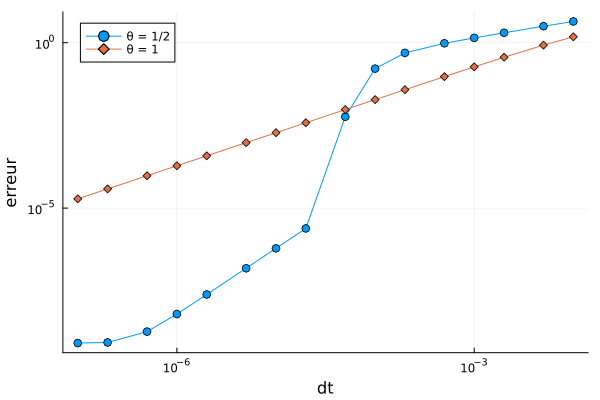

In [8]:
using LinearAlgebra: norm

all_dt = vcat(10^-2, [[5, 2, 1] * 10.0^-k for k in 3:7]...) # `...` déplie le tableau et `vcat` concatène les tableaux
# plus pratique mais ne correspond pas à l'énoncé :
# all_dt = 10 .^ -range(2.0, 7.0, length=10))
all_Nt = ceil.(Int64, T ./ all_dt)
all_dt = T ./ all_Nt # répare les potentielles erreurs de troncature de `ceil`

err_half = zeros(length(all_Nt)) # pour theta = 1/2
err_one = zeros(length(all_Nt)) # pour theta = 1
for (i, Nt) in enumerate(all_Nt)
    x, u = simulate_theta_scheme(initial_condition, Nx, T, Nt, θ = 0.5)
    err_half[i] = norm(u_ref - u)
    x, u = simulate_theta_scheme(initial_condition, Nx, T, Nt, θ = 1.0)
    err_one[i] = norm(u_ref - u)
end
plot(xscale=:log10, yscale=:log10, legend=:topleft, xlabel="dt", ylabel="erreur")
plot!(all_dt, err_half, label="θ = 1/2", marker=:o)
plot!(all_dt, err_one, label="θ = 1", marker=:d)

In [9]:
println(@allocations simulate_theta_scheme(initial_condition, Nx, T, 10,    θ = 0.8))
println(@allocations simulate_theta_scheme(initial_condition, Nx, T, 100,   θ = 0.8))
println(@allocations simulate_theta_scheme(initial_condition, Nx, T, 1000,  θ = 0.8))
println(@allocations simulate_theta_scheme(initial_condition, Nx, T, 10000, θ = 0.8))

46


46
47


47
